# Using label Propogation pipeline to label and classify mock data

This notebook demonstrate how to use the label propagation code to label clothing data. The data used in this example is a Mock dataset randomly generated using the 100  most common words for each category in the actual data used in the paper that accompanies this work. 



In [1]:
# Python imports
import json
import numpy as np
import pandas as pd
from importlib import reload

# plotting imports
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib notebook

# scikit lean imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  confusion_matrix, classification_report

# Custom imports of files to run label propagation pipeline
import labelling_pipeline
import Word_vectors

C:\Python36\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Read in data
First read in the seed labels that will be used for fuzzy matching and label propagation

In [2]:
# seed labels
with open('seed_labels.json', 'r') as f:
    seed_labels = json.load(f)

Now read in the mock data to be labelled 

In [3]:
# Read in data 
df_mock = pd.read_csv('clothing_mock_data.csv', encoding="ISO-8859-1")

Prevelance of items in the mock dataset

In [4]:
print('Number of items for each label')
for lab in np.sort(df_mock.true_label.unique()):
    print(f"{len(df_mock[df_mock['true_label'] == lab])} items with label {lab} ")

Number of items for each label
1104 items with label 0 
434 items with label 1 
393 items with label 2 
75 items with label 3 
576 items with label 4 
514 items with label 5 
395 items with label 6 
243 items with label 7 
261 items with label 8 


**create a test train split**

In [5]:
 X_train, X_test, y_train, y_test = train_test_split(df_mock.drop('true_label', axis=1), df_mock['true_label'],
                                                     test_size=0.20, stratify=df_mock['true_label'])

#### List of primary genders, categories 
This is used to help with selecting sub-set to match with and to clean the fuzzy matching to ensure maximum accuracy for the labels going into label propagation

In [6]:
# gender for each category
divisions=['Womens', 'Men', 'Womens', 'Womens', 'Boys', 'Girls', 'Men', 'Men']
# broad categories for fuzzy matching cleaning
categories=['Coats', 'Shirts', 'Fitness & activewear', 'Swim', 'Jeans', 'Tops', 'Underwear', 'Underwear']

# list of stopwords for use in word vectors
stop = ['pack', 'print', 'printed', 'sleeve', 'long', 'fit', 'f', 't', 's', 'asos', 'stripe', 'slim', 'running', 'active']

# names for output cleaned/labeled dataframes
outs = ['coats', 'shirts', 'shorts', 'swim', 'jeans', 'tops', 'pants', 'socks']


## Perform Label propogation for each category in turn 


In [7]:
# parameters for the label propagation for each kind of word vector in tern
param_doc2vec = {'alpha': 0.01, 'kernel': 'knn', 'n_neighbors': 6}
param_tfidf = {'alpha': 0.01, 'kernel': 'knn', 'n_neighbors': 6}
param_count = {'alpha': 0.01, 'kernel': 'knn', 'n_neighbors': 6}

# empty dictinary to collect results of each category
clean_frames = dict()

# loop through the labelling pipeline for each output category
for i in range(len(outs)):
    print('\n** ',outs[i])
    
    # select only the correct gender - assume the gender column is reliabel

    temp = X_train.loc[(X_train['division'] == divisions[i]) ]
    
    # perform matching and cleaning 
    cleaned = labelling_pipeline.labelling_pipeline(temp,names=temp['name'],nwords=10,
                                                    stopwords=stop, fuzzy_thres=70,
                                                    edit_thres=30, jacard_thres=0.30,
                                                    fuzzy_neg=25, edit_neg=75, jacard_neg=0.75,
                                                    item_id=1, label_names=seed_labels[str(i)],
                                                    param_doc2vec=param_doc2vec,common_words=False,
                                                    param_tfidf=param_tfidf, param_count=param_count,
                                                    cat_clean=True, negative_labels=False,
                                                    division=divisions[i],category=categories[i],
                                                    doc2vec_thresh=0.7,tfidf_thresh=0.7,
                                                    count_thresh=0.7,n_negative=15,
                                                    wv_names=['word2vec','fast','tfidf'])
    clean_frames[outs[i]] = cleaned
    
print('labelled')


**  coats
Cleaning with common words
cleaned:  1082
Fuzzy Matching


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Word Vectors
Number of fuzzyMatch labels: 11
Number of negative labels: 62
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:264: RuntimeWarning: inval

label propogation: fast


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: inval

label propogation: TF-IDF


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:234: RuntimeWarning: inval


**  shirts
Cleaning with common words
cleaned:  948
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 60
Number of negative labels: 30
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:264: RuntimeWarning: inval

label propogation: fast


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: inval

label propogation: TF-IDF


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:234: RuntimeWarning: inval


**  shorts
Cleaning with common words
cleaned:  1082
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 15
Number of negative labels: 39
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:264: RuntimeWarning: inval

label propogation: fast


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: inval

label propogation: TF-IDF


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:234: RuntimeWarning: inval


**  swim
Cleaning with common words
cleaned:  1082
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 210
Number of negative labels: 78
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:264: RuntimeWarning: inval

label propogation: fast


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: inval

label propogation: TF-IDF


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



**  jeans
Cleaning with common words
cleaned:  638
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 42
Number of negative labels: 12
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:264: RuntimeWarning: inval

label propogation: fast
label propogation: TF-IDF


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:234: RuntimeWarning: inval


**  tops
Cleaning with common words
cleaned:  528
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 50
Number of negative labels: 51
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


label propogation: fast


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: inval

label propogation: TF-IDF


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



**  pants
Cleaning with common words
cleaned:  948
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 48
Number of negative labels: 44
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:264: RuntimeWarning: inval

label propogation: fast


C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: invalid value encountered in greater_equal
  'label_labprop_fast'] = 1
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:280: RuntimeWarning: invalid value encountered in greater_equal
  'label_labprop_fast'] = 0


label propogation: TF-IDF


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



**  socks
Cleaning with common words
cleaned:  948
Fuzzy Matching
Word Vectors
Number of fuzzyMatch labels: 38
Number of negative labels: 111
Label Propogation
label propogation: word2vec


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


label propogation: fast


C:\Python36\lib\site-packages\sklearn\semi_supervised\label_propagation.py:297: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\My_Git\Prices_classifier_project\code_4_paper\labelling_pipeline.py:278: RuntimeWarning: inval

label propogation: TF-IDF


C:\Python36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


labelled


### Combine the labels across iterations 

If a label is assigned in more than one loop it is assigned -1 for unlabelled
If a label is assigned and then a 0 is also assigned the label outranks the 0
If no label has been assigned ever then assume it is junk


In [8]:
# combine_labels for all categories
label_dict={'other':0,'coats':1, 'shirts':2, 'shorts':3, 'swim':4, 'jeans':5, 'tops':6, 'pants':7, 'socks':8}

X_train['label_combined'] = -10000
X_train['lab_count'] =0 
X_train['zero_count'] = 0

# loop through the 
for i, frame in enumerate(list(clean_frames.keys())):
    X_train[label_dict[frame]]=np.nan
    index = clean_frames[frame].index
    
    X_train.loc[index, label_dict[frame]] = clean_frames[frame]['label_labprop']
    X_train.loc[(X_train[label_dict[frame]]==1), 'lab_count']+=1
    X_train.loc[(X_train[label_dict[frame]]==0), 'zero_count']+=1
    
    X_train.loc[(X_train['lab_count']>1), 'label_combined']=-1
    
    X_train.loc[(X_train[label_dict[frame]]==1)&
               (X_train['lab_count']==1), 'label_combined'] = label_dict[frame]
    X_train.loc[(X_train[label_dict[frame]]==0)&
               (X_train['zero_count']==i+1), 'label_combined'] = 0
    X_train.loc[(X_train[label_dict[frame]]==-1)&
               (X_train['lab_count']==0), 'label_combined']=-1
    
    X_train.loc[X_train['label_combined']==-10000, 'label_combined']=0

## Examine the results of the label propagation pipeline

**Numer of labels assigned**

In [9]:
print(f'Number of labels assigned: {len(X_train[X_train.label_combined>-1])}')
print(f'Number of unlabelled items: {len(X_train[X_train.label_combined==-1])}')

Number of labels assigned: 2590
Number of unlabelled items: 606


#### Classification report for labelled items

In [10]:
print(classification_report(y_train.loc[(X_train.label_combined>-1)],
                            X_train.loc[(X_train.label_combined>-1),'label_combined']))

              precision    recall  f1-score   support

           0       0.57      0.89      0.69       562
           1       0.97      0.40      0.57       300
           2       0.89      0.95      0.92       311
           3       1.00      0.88      0.94        59
           4       0.99      0.94      0.96       452
           5       0.97      0.92      0.95       398
           6       0.99      0.67      0.80       283
           7       0.46      0.91      0.61        86
           8       0.82      0.17      0.28       139

   micro avg       0.79      0.79      0.79      2590
   macro avg       0.85      0.75      0.75      2590
weighted avg       0.86      0.79      0.78      2590



#### Confusion matrix for labelled items

<IPython.core.display.Javascript object>


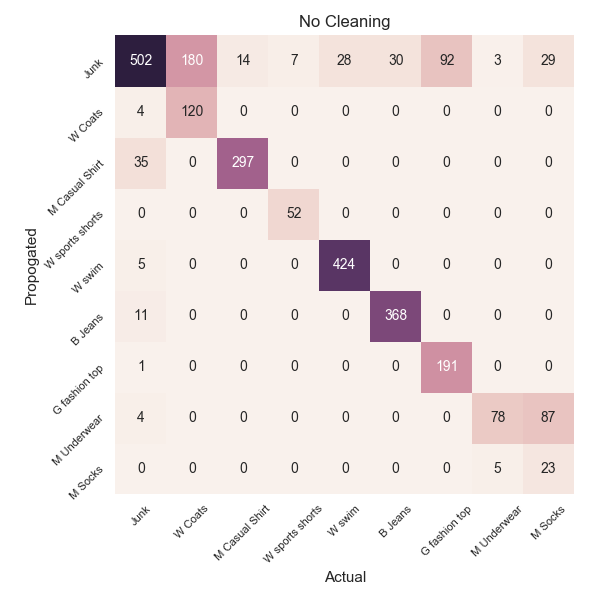

In [11]:
mat = confusion_matrix(y_train.loc[(X_train.label_combined>-1)],
                       X_train.loc[(X_train.label_combined>-1),'label_combined'])
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)

ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'][::-1],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

ax.set_title('No Cleaning')
ax.set_xlabel('Actual')
ax.set_ylabel('Propogated')
fig.tight_layout()    

The labels have been propagated accuratly for most labels. This has not worked as well for the Mens Socks and Mens Pants categories. This is likely due to the shared language between socks and underwear as well as them falling in to the same broad category underwear. As this is a mock dataset the word order of the product names does not make sense and this may of impacted the quality of the fuzzy matching

# Train a classifiers

Now we have the labelled data we can use it to train a classifier. 
In this example notebook we have only used the fastText vectors in the classifier it is quite easy to instead use other word vectors.

### Create word vectors
Want to create the word vectors from the largest possible vocabulary so use the whole mock dataset

In [12]:
# get words for word_vectors
names=Word_vectors.remove_stopwords(df_mock['name'])

print('create models')

print('tfidf')
tfidf_mat,tf_mod = Word_vectors.TF_IDF(names.values, ngram_range=(1, 2),
                                       print_sim=False,max_features=50)
df_mock['tfidf'] = tfidf_mat.toarray().tolist()

print('count_vec')
count_mat,count_mod = Word_vectors.count_vectorizer(names.values, ngram_range=(1, 2),
                                                    print_sim=False,max_features=50)
df_mock['count_vec'] = count_mat.toarray().tolist()
names
ft_vectors, model_fasttext = Word_vectors.fasttext_vectors(names)
df_mock['fasttext_vec'] = ft_vectors.tolist()

w2v_vectors, model_w2v = Word_vectors.fit_word2vec(names)
df_mock['w2v_vec'] = w2v_vectors.tolist()


create models
tfidf
count_vec


**Infer word vectors for labelled training data and the test data**

In [13]:
reload(Word_vectors)
print('infer labelled data vectors')

names_train=Word_vectors.remove_stopwords(X_train['name'])


X_train['tfidf'] = tf_mod.transform(names_train).toarray().tolist()
X_train['count_vec'] = count_mod.transform(names_train).toarray().tolist()
X_train['fasttex']=Word_vectors.fasttext_infvec(names_train,model_fasttext).tolist()
X_train['word2vec']=Word_vectors.word2vec(names_train,model_w2v).tolist()

print('infer unlabelled vectors')
names_test=Word_vectors.remove_stopwords(X_test['name'])
    
X_test['tfidf'] = tf_mod.transform(names_test).toarray().tolist()
X_test['count_vec']=count_mod.transform(names_test).toarray().tolist()
X_test['fasttex']=Word_vectors.fasttext_infvec(names_test,model_fasttext).tolist()
X_test['word2vec']=Word_vectors.word2vec(names_test,model_w2v).tolist()


infer labelled data vectors
infer unlabelled vectors


### Create label encodings for the categorical columns division, category and and subcategory 
The encodings are created on the shole test data then applied to test and train

In [14]:
div_code = LabelEncoder().fit(df_mock.division)
cat_code = LabelEncoder().fit(df_mock.category)
subcat_code = LabelEncoder().fit(df_mock.subcategory)

In [15]:
X_train['division_code']=div_code.transform(X_train.division)
X_train['category_code']=cat_code.transform(X_train.category)
X_train['subcategory_code']=subcat_code.transform(X_train.subcategory)


X_test['division_code']=div_code.transform(X_test.division)
X_test['category_code']=cat_code.transform(X_test.category)
X_test['subcategory_code']=subcat_code.transform(X_test.subcategory)



### Create the training dataset with only the products assigned a label, not -1 prodcuts

In [16]:
labelled=X_train[X_train['label_combined']>-1]
labelled_y=y_train[X_train['label_combined']>-1]

**Need to stack together all the inputs for the classifiers inorder to use the word vectors with the categorical variables**

In [17]:
# Stack X train inputs
X_train_in = np.stack(labelled[['division_code', 'category_code', 'subcategory_code']].values)
X_train_in = np.concatenate((X_train_in,np.stack(labelled['fasttex'])),axis=1)


# # stack unlabelled inputs 
X_test_in = np.stack(X_test[['division_code', 'category_code', 'subcategory_code']].values)
X_test_in = np.concatenate((X_test_in,np.stack(X_test['fasttex'])),axis=1)


## Decision Tree

Build a decision tree with the fastText vectors. No rigourious hyper-parameter search has been undertaken only a basic grid search.

Best fit parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 7}

*** Training labelled data set against true labels***
              precision    recall  f1-score   support

           0       0.59      0.95      0.73       562
           1       1.00      0.37      0.54       300
           2       0.91      0.99      0.95       311
           3       1.00      0.95      0.97        59
           4       1.00      1.00      1.00       452
           5       1.00      0.91      0.96       398
           6       1.00      0.59      0.74       283
           7       0.49      0.97      0.65        86
           8       0.93      0.19      0.31       139

   micro avg       0.81      0.81      0.81      2590
   macro avg       0.88      0.77      0.76      2590
weighted avg       0.88      0.81      0.80      2590


*** Test split of labelled data set ***
              precision    recall  f1-score   support

           0       0.65      0.93      0.76       221
   

<IPython.core.display.Javascript object>


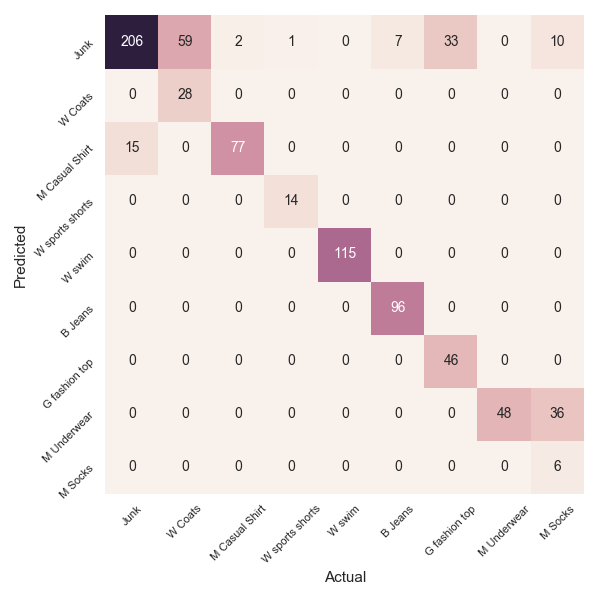

In [18]:
param_grid = [{'max_depth':[5,10,20,30,50],'min_samples_leaf':[5,10,15,20,25],'min_samples_split':[2,5,7,10,20]}]
dt_clf = GridSearchCV(estimator= DecisionTreeClassifier(class_weight='balanced'),param_grid=param_grid,cv=5)
dt_clf.fit(X_train_in,labelled['label_combined'])

dt_params = dt_clf.best_params_

print(f'Best fit parameters: {dt_params}')

dt_clf = DecisionTreeClassifier(**dt_params)
dt_clf.fit(X_train_in,labelled['label_combined'])

ind = np.argsort(dt_clf.feature_importances_)[::-1]

print('\n*** Training labelled data set against true labels***')

print(classification_report(labelled_y,dt_clf.predict(X_train_in)))


predict_dt=dt_clf.predict(X_test_in)
print('\n*** Test split of labelled data set ***')
print(classification_report(y_test,predict_dt))

mat = confusion_matrix(y_test,predict_dt)
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'][::-1],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.tight_layout()


The decision tree works reasonaly well with the poorly performing items being the same as those that did not perform so well in propagation

## Random Forest

Build a random forest with the fastText vectors. No rigourious hyper-parameter search has been undertaken only a basic grid search.

C:\Python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best fit parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 7}

*** Training labelled data set against true labels***
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       562
           1       0.97      0.50      0.66       300
           2       0.93      1.00      0.96       311
           3       1.00      1.00      1.00        59
           4       1.00      1.00      1.00       452
           5       1.00      1.00      1.00       398
           6       1.00      0.99      0.99       283
           7       0.43      0.97      0.60        86
           8       0.91      0.22      0.35       139

   micro avg       0.89      0.89      0.89      2590
   macro avg       0.89      0.85      0.82      2590
weighted avg       0.92      0.89      0.88      2590


*** Test split of labelled data set ***
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       221
   

<IPython.core.display.Javascript object>


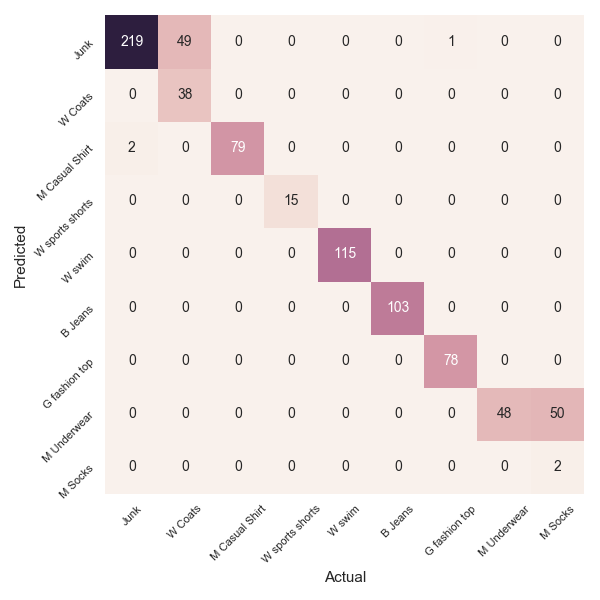

In [19]:
param_grid = [{'n_estimators':[5,10,20,30,50],'max_depth':[5,10,20,30,50,100],'min_samples_leaf':[1,3,5,10,15]}]
rf_clf = GridSearchCV(estimator= RandomForestClassifier(class_weight='balanced'),param_grid=param_grid,cv=5)
rf_clf.fit(X_train_in,labelled['label_combined'])
rf_parm = rf_clf.best_params_

print(f'Best fit parameters: {dt_params}')

rf_clf = RandomForestClassifier(**rf_parm,class_weight='balanced') #max_depth=10,min_samples_leaf=5)
rf_clf.fit(X_train_in,labelled['label_combined'])


print('\n*** Training labelled data set against true labels***')
print(classification_report(labelled_y,rf_clf.predict(X_train_in)))


predict_rf=rf_clf.predict(X_test_in)
print('\n*** Test split of labelled data set ***')
print(classification_report(y_test,predict_rf))

mat = confusion_matrix(y_test,predict_rf)
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

predict_rf=rf_clf.predict(X_test_in)

ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'][::-1],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.tight_layout()
# fig.savefig('fasttext_rf_confusion.png')    

The random forest is performing better accross most categories but is unable to distinguish socks and underwear. Aain this is where the label propagation performed worse. 

## Suport vector machine

Build a SVM with the fastText vectors. No rigourious hyper-parameter search has been undertaken only a basic grid search.

Best fit parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 7}

*** Training labelled data set against true labels***
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       562
           1       0.00      0.00      0.00       300
           2       1.00      1.00      1.00       311
           3       1.00      1.00      1.00        59
           4       1.00      1.00      1.00       452
           5       1.00      1.00      1.00       398
           6       1.00      0.99      0.99       283
           7       0.38      1.00      0.55        86
           8       0.00      0.00      0.00       139

   micro avg       0.83      0.83      0.83      2590
   macro avg       0.67      0.78      0.70      2590
weighted avg       0.73      0.83      0.77      2590


*** Test split of labelled data set ***
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       221
   

C:\Python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


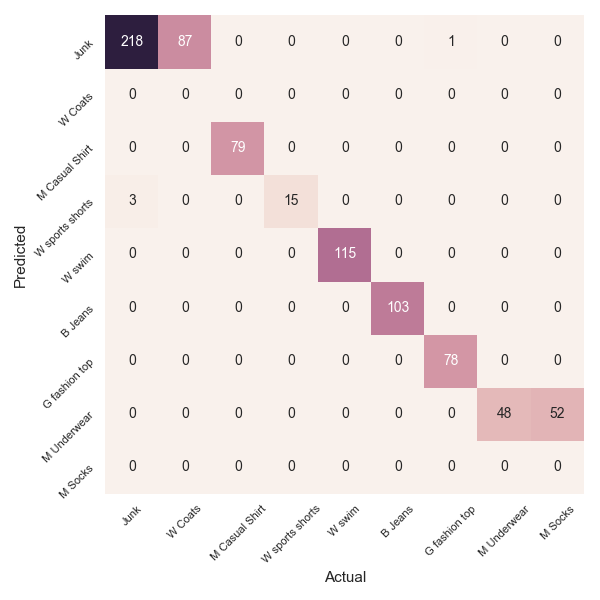

In [23]:
param_grid = [{'C':[10,100,1000,2000,5000,10000,20000],'gamma':[0.0,0.00001,0.00005,0.0001,0.01],'kernel':['rbf']}]

svm_clf = GridSearchCV(estimator=SVC(probability=True),param_grid=param_grid,cv=5)
svm_clf.fit(X_train_in,labelled['label_combined'])
svm_param = svm_clf.best_params_
print(f"Best fit parameters: {dt_params}")

svm_clf = SVC(**svm_param, probability=True) #max_depth=10,min_samples_leaf=5)
svm_clf.fit(X_train_in,labelled['label_combined'])

predict_svm=svm_clf.predict(X_test_in)

print('\n*** Training labelled data set against true labels***')
print(classification_report(labelled_y,svm_clf.predict(X_train_in)))


print('\n*** Test split of labelled data set ***')
print(classification_report(y_test,predict_svm))

mat = confusion_matrix(y_test,predict_svm)
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

predict_proba=svm_clf.predict_proba(X_test_in)


ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'][::-1],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.tight_layout()

The SVM has given similar results to the decision tree, performing very well except where the label propagation has done poorly.


This notebook is intended to demonstate the methods of paper Semi-supervised machine learning with word embedding for classification in price statistics, Martindale et.al. using a mock dataset. 
We are not attempting to recreate the results of the paper as we can not make the data publicly avalible instead the mock dataset gives a demonstataion of the code. We do however see generally similar trends as with the true data. For more methods data see the paper.
